In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from pprint import pprint as pp
import csv
from pathlib import Path
import seaborn as sns
from itertools import product
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.metrics import homogeneity_score, silhouette_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans, DBSCAN

import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary

from typing import List, Tuple

In [ ]:
pd.set_option('display.max_columns', 700)
pd.set_option('display.max_rows', 400)
pd.set_option('display.min_rows', 10)
pd.set_option('display.expand_frame_repr', True)

In [ ]:
data = Path.cwd() / 'data' / 'fraud_detection'

ch1 = data / 'chapter_1'
cc1_file = ch1 / 'creditcard_sampledata.csv'
cc3_file = ch1 / 'creditcard_sampledata_3.csv'

ch2 = data / 'chapter_2'
cc2_file = ch2 / 'creditcard_sampledata_2.csv'

ch3 = data / 'chapter_3'
banksim_file = ch3 / 'banksim.csv'
banksim_adj_file = ch3 / 'banksim_adj.csv'
db_full_file = ch3 / 'db_full.pickle'
labels_file = ch3 / 'labels.pickle'
labels_full_file = ch3 / 'labels_full.pickle'
x_scaled_file = ch3 / 'x_scaled.pickle'
x_scaled_full_file = ch3 / 'x_scaled_full.pickle'

ch4 = data / 'chapter_4'
enron_emails_clean_file = ch4 / 'enron_emails_clean.csv'
cleantext_file = ch4 / 'cleantext.pickle'
corpus_file = ch4 / 'corpus.pickle'
dict_file = ch4 / 'dict.pickle'
ldamodel_file = ch4 / 'ldamodel.pickle'

In [ ]:
df = pd.read_csv('creditcard_sampledata_3.csv', encoding = 'unicode_escape')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5050 entries, 0 to 5049
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  5050 non-null   int64  
 1   V1          5050 non-null   float64
 2   V2          5050 non-null   float64
 3   V3          5050 non-null   float64
 4   V4          5050 non-null   float64
 5   V5          5050 non-null   float64
 6   V6          5050 non-null   float64
 7   V7          5050 non-null   float64
 8   V8          5050 non-null   float64
 9   V9          5050 non-null   float64
 10  V10         5050 non-null   float64
 11  V11         5050 non-null   float64
 12  V12         5050 non-null   float64
 13  V13         5050 non-null   float64
 14  V14         5050 non-null   float64
 15  V15         5050 non-null   float64
 16  V16         5050 non-null   float64
 17  V17         5050 non-null   float64
 18  V18         5050 non-null   float64
 19  V19         5050 non-null  

In [ ]:
df.head()

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,258647,1.725265,-1.337256,-1.012687,-0.361656,-1.431611,-1.098681,-0.842274,-0.026594,-0.032409,0.215113,1.618952,-0.654046,-1.442665,-1.546538,-0.230008,1.785539,1.419793,0.071666,0.233031,0.275911,0.414524,0.793434,0.028887,0.419421,-0.367529,-0.155634,-0.015768,0.010790,189.00,0
1,69263,0.683254,-1.681875,0.533349,-0.326064,-1.455603,0.101832,-0.520590,0.114036,-0.601760,0.444011,1.521570,0.499202,-0.127849,-0.237253,-0.752351,0.667190,0.724785,-1.736615,0.702088,0.638186,0.116898,-0.304605,-0.125547,0.244848,0.069163,-0.460712,-0.017068,0.063542,315.17,0
2,96552,1.067973,-0.656667,1.029738,0.253899,-1.172715,0.073232,-0.745771,0.249803,1.383057,-0.483771,-0.782780,0.005242,-1.273288,-0.269260,0.091287,-0.347973,0.495328,-0.925949,0.099138,-0.083859,-0.189315,-0.426743,0.079539,0.129692,0.002778,0.970498,-0.035056,0.017313,59.98,0
3,281898,0.119513,0.729275,-1.678879,-1.551408,3.128914,3.210632,0.356276,0.920374,-0.160589,-0.801748,0.137341,-0.156740,-0.429388,-0.752392,0.155272,0.215068,0.352222,-0.376168,-0.398920,0.043715,-0.335825,-0.906171,0.108350,0.593062,-0.424303,0.164201,0.245881,0.071029,0.89,0
4,86917,1.271253,0.275694,0.159568,1.003096,-0.128535,-0.608730,0.088777,-0.145336,0.156047,0.022707,-0.963306,-0.228074,-0.324933,0.390609,1.065923,0.285930,-0.627072,0.170175,-0.215912,-0.147394,0.031958,0.123503,-0.174528,-0.147535,0.735909,-0.262270,0.015577,0.015955,6.53,0


In [ ]:
# Count the occurrences of fraud and no fraud and print them
occ = df['Class'].value_counts()
occ

Class
0    5000
1      50
Name: count, dtype: int64

In [ ]:
# Print the ratio of fraud cases
ratio_cases = occ/len(df.index)
print(f'Ratio of fraudulent cases: {ratio_cases[1]}\nRatio of non-fraudulent cases: {ratio_cases[0]}')

Ratio of fraudulent cases: 0.009900990099009901
Ratio of non-fraudulent cases: 0.9900990099009901


In [ ]:
def prep_data(df: pd.DataFrame) -> (np.ndarray, np.ndarray):
    """
    Convert the DataFrame into two variable
    X: data columns (V1 - V28)
    y: lable column
    """
    X = df.iloc[:, 2:30].values
    y = df.Class.values
    return X, y

In [ ]:
# Define a function to create a scatter plot of our data and labels
def plot_data(X: np.ndarray, y: np.ndarray):
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.legend()
    return plt.show()

In [ ]:
# Create X and y from the prep_data function
X, y = prep_data(df)

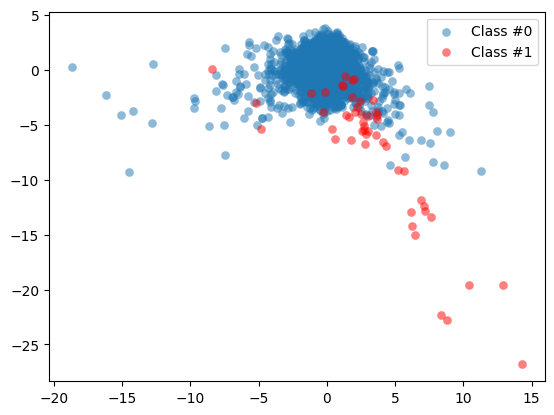

In [ ]:
# Plot our data by running our plot data function on X and y
plot_data(X, y)

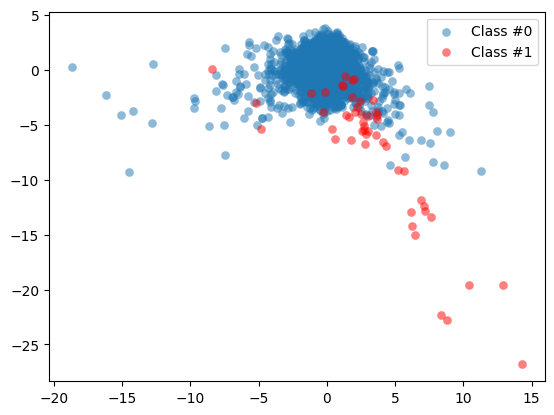

In [ ]:
plt.scatter(df.V2[df.Class == 0], df.V3[df.Class == 0], label="Class #0", alpha=0.5, linewidth=0.15)
plt.scatter(df.V2[df.Class == 1], df.V3[df.Class == 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
plt.legend()
plt.show()

In [ ]:
# Import the necessary libraries
from imblearn.over_sampling import RandomOverSampler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define a function to prepare the data
def prep_data(df):
    # Extract features and labels
    X = df.iloc[:, 2:4].values
    y = df.iloc[:, 4].values
    return X, y

# Define a function to create a scatter plot of our data and labels
def plot_data(X: np.ndarray, y: np.ndarray):
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.legend()
    return plt.show()

# Define a function to compare

In [ ]:
!pip show smote

Name: smote
Version: 0.1
Summary: UNKNOWN
Home-page: https://github.com/chupati/smote
Author: David N. Sanchez
Author-email: dsanchez@dnsai.io
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy, scikit-learn
Required-by: 


In [ ]:
help(method)

Help on SMOTE in module imblearn.over_sampling._smote.base object:

class SMOTE(BaseSMOTE)
 |  SMOTE(*, sampling_strategy='auto', random_state=None, k_neighbors=5, n_jobs=None)
 |  
 |  Class to perform over-sampling using SMOTE.
 |  
 |  This object is an implementation of SMOTE - Synthetic Minority
 |  Over-sampling Technique as presented in [1]_.
 |  
 |  Read more in the :ref:`User Guide <smote_adasyn>`.
 |  
 |  Parameters
 |  ----------
 |  sampling_strategy : float, str, dict or callable, default='auto'
 |      Sampling information to resample the data set.
 |  
 |      - When ``float``, it corresponds to the desired ratio of the number of
 |        samples in the minority class over the number of samples in the
 |        majority class after resampling. Therefore, the ratio is expressed as
 |        :math:`\alpha_{os} = N_{rm} / N_{M}` where :math:`N_{rm}` is the
 |        number of samples in the minority class after resampling and
 |        :math:`N_{M}` is the number of samp

In [ ]:
!pip install --upgrade smote

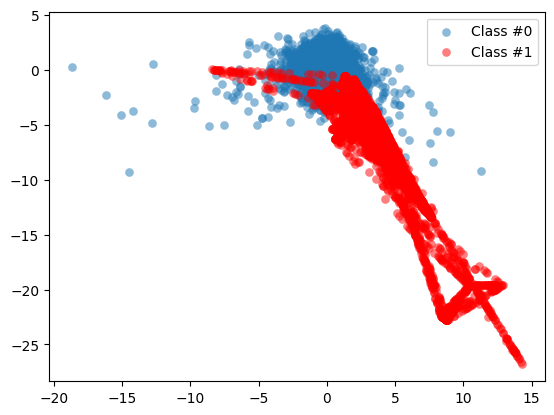

In [ ]:
# Import the necessary libraries
from imblearn.over_sampling import SMOTE  # Corrected the import statement
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define a function to prepare the data
def prep_data(df):
    # Extract features and labels
    X = df.iloc[:, 2:4].values
    y = df.iloc[:, 4].values
    return X, y

# Define a function to create a scatter plot of our data and labels
def plot_data(X: np.ndarray, y: np.ndarray):
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.legend()
    return plt.show()

# Define a function to compare

# Instantiate the SMOTE object
smote = SMOTE(random_state=42)  # Corrected the object name

# Resample the data
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Plot the resampled data
plot_data(X_resampled, y_resampled)

In [ ]:
X_resampled, y_resampled = method.fit_resample(X_train, y_train)

In [ ]:
method = SMOTE(sampling_strategy='auto')

In [ ]:
# Define resampling method and split into train and test
method =  SMOTE(sampling_strategy='minority')
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

# Apply resampling to the training data only
X_resampled, y_resampled = method.fit_resample(X_train, y_train)

# Continue fitting the model and obtain predictions
model = LogisticRegression()
model.fit(X_resampled, y_resampled)

# Get model performance metrics
predicted = model.predict(X_test)
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1004
           1       0.62      0.83      0.71         6

    accuracy                           1.00      1010
   macro avg       0.81      0.92      0.86      1010
weighted avg       1.00      1.00      1.00      1010



In [ ]:
# Run the prep_data function
X, y = prep_data(df)

In [ ]:
print(f'X shape: {X.shape}\ny shape: {y.shape}')

X shape: (5050, 2)
y shape: (5050,)


In [ ]:
# Define the resampling method
method = SMOTE()

In [ ]:
# Convert the target variable to binary
y = pd.cut(y, bins=2, labels=[0, 1])

# Apply SMOTE resampling
method = SMOTE()
X_resampled, y_resampled = method.fit_resample(X, y)

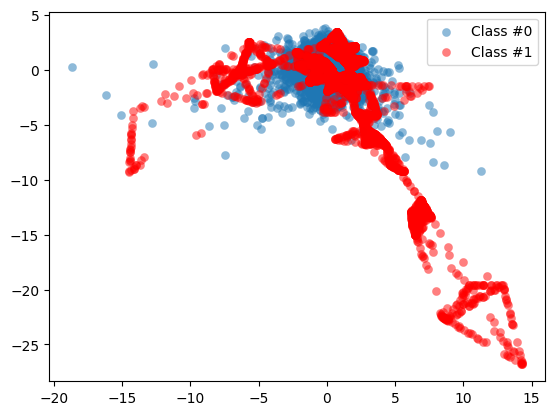

In [ ]:
# Plot the resampled data
plot_data(X_resampled, y_resampled)

In [ ]:
pd.value_counts(pd.Series(y))

0    4920
1     130
Name: count, dtype: int64

In [ ]:
pd.value_counts(pd.Series(y_resampled))

0    4920
1    4920
Name: count, dtype: int64

In [ ]:
def compare_plot(X: np.ndarray, y: np.ndarray, X_resampled: np.ndarray, y_resampled: np.ndarray, method: str):
    plt.subplot(1, 2, 1)
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.title('Original Set')
    plt.subplot(1, 2, 2)
    plt.scatter(X_resampled[y_resampled == 0, 0], X_resampled[y_resampled == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X_resampled[y_resampled == 1, 0], X_resampled[y_resampled == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.title(method)
    plt.legend()
    plt.show()

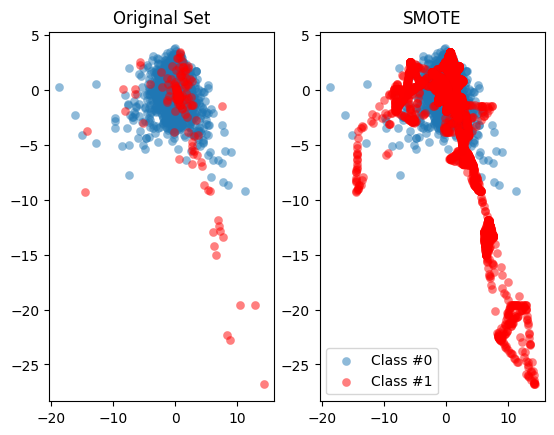

In [ ]:
compare_plot(X, y, X_resampled, y_resampled, method='SMOTE')